In [98]:
import sys
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from mmengine.config import Config
from opentad.datasets import build_dataset, build_dataloader
from opentad.datasets.base import SlidingWindowDataset, PaddingDataset, filter_same_annotation
from opentad.datasets.pku import PkuSlidingDataset, PkuPaddingDataset

sys.path.append(str(Path.cwd()))
print("lib import completed")

lib import completed


In [99]:
config_path = "configs/adatad/pku_mmd/e2e_pku_mmd_videomae_s_768x1_160_adapter copy.py"
cfg = Config.fromfile(config_path)
print("config file load")
print("path : {config_path}")
print("keys : {list(cfg.keys())}")


config file load
path : {config_path}
keys : {list(cfg.keys())}


In [101]:
if hasattr(cfg, "dataset"):
    dataset_cfg = cfg.dataset
    print(f"dataset_cfg keys: {list(dataset_cfg.keys())}")

    if hasattr(dataset_cfg, 'train'):
        train_cfg = dataset_cfg.train
        print(f"train_cfg settings")
        print(f"type : {train_cfg.get('type', 'Unknown')}")
        print(f"ann_file : {train_cfg.get('ann_file', 'Unknown')}")
        print(f"data path : {train_cfg.get('data_prefix', 'Unknown')}")
        print(f"pipelines : {len(train_cfg.get('pipeline', []))}")
else:
    print("dataset_cfg x")

dataset_cfg keys: ['train', 'val', 'test']
train_cfg settings
type : PkuPaddingDataset
ann_file : data/PKU-MMD/pku_train.json
data path : Unknown
pipelines : 13


In [102]:
cfg = Config.fromfile(config_path)

train_dataset = build_dataset(cfg.dataset.train)

train_loader = build_dataloader(
    train_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)

training subset: 831 videos


In [103]:
if 'train_dataset' in locals():
    sample = train_dataset[0]
    print(f"train dataset sample keys : {list(sample.keys())}")

    for key, value in sample.items():
        print(f"{key}")
        print(f"type: {type(value)}")

        if hasattr(value, 'shape'):
            print(f"shape: {value.shape}")
            print(f"data type: {value.dtype}")
            
            if hasattr(value, 'min') and hasattr(value, 'max'):
                print(f"value range: {value.min().item():.3f} ~ {value.max().item():.3f}")

            elif isinstance(value, list):
                print(f"list length: {len(value)}")
                if len(value) > 0:
                    print(f"first element type: {type(value[0])}")
            
            elif isinstance(value, dict):
                print(f"dict keys: {list(value.keys())}")
            else:
                print(f"value: {value}")
    else:
        print(f"no dataset")

train dataset sample keys : ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']
inputs
type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 512, 160, 160])
data type: torch.uint8
value range: 0.000 ~ 255.000
masks
type: <class 'torch.Tensor'>
shape: torch.Size([512])
data type: torch.bool
value range: 1.000 ~ 1.000
gt_segments
type: <class 'torch.Tensor'>
shape: torch.Size([3, 2])
data type: torch.float32
value range: 131.000 ~ 512.000
gt_labels
type: <class 'torch.Tensor'>
shape: torch.Size([3])
data type: torch.int32
value range: 7.000 ~ 40.000
metas
type: <class 'dict'>
no dataset


In [104]:
cfg = Config.fromfile(config_path)

val_dataset = build_dataset(cfg.dataset.val)

val_loader = build_dataloader(
    val_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)

test_dataset = build_dataset(cfg.dataset.test)

test_loader = build_dataloader(
    test_dataset,
    rank=0,
    world_size=1,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    drop_last=False
)
try:
    adatad_loader = build_dataloader(
        train_dataset,
        rank=0,
        world_size=1,
        batch_size=2,
        num_workers=0,
        shuffle=True,
        drop_last=False
    )
    for batch_idx, data_dict in enumerate(adatad_loader):
        if batch_idx == 0:
            print(f" build success")
            print(f" batch keys: {list(data_dict.keys())}")
            break
except Exception as e:
    print(f"Error : {e}")
    import traceback
    traceback.print_exc()
        

validation subset: 111 videos, truncated as 1958 windows.
testing subset: 132 videos, truncated as 2370 windows.
 build success
 batch keys: ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']


In [105]:
first_sample = train_dataset[0]
print(f"first sample metadata:")
for key, value in first_sample.items():
    if key not in ['inputs', 'masks', 'gt_segments', 'gt_labels']:
        print(f"{key}: {value}")

if 'video_name' in first_sample:
    print(f"video name: {first_sample['video_name']}")

if 'windows_start_frame' in first_sample:
    print(f"windows start frame: {first_sample['windows_start_frame']}")



if 'duration' in first_sample:
    print(f"duration: {first_sample['duration']}")

if 'fps' in first_sample:
    print(f"fps: {first_sample['fps']}")

if 'snippet_stride' in first_sample:
    print(f"snippet stride: {first_sample['snippet_stride']}")
    

first sample metadata:
metas: {'video_name': '0002-L', 'data_path': 'F:/dataset/pku-mmd/rgb', 'fps': 30.0, 'duration': 4462, 'snippet_stride': 1, 'window_size': 512, 'offset_frames': 0}


In [ ]:
def visualize_pku_batch_sample(data_dict, sample_idx=0, title=sample):
    if 'inputs' in data_dict:
        inputs = data_dict['inputs'] 
        
        sample_inputs = inputs[sample_idx]

        T = sample_inputs.shape[1]
        frame_indices = np.linspace(0, T-1, 8, dtype=int)

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'{title} (sample {sample_idx})', fontsize=16)

        for idx, frame_idx in enumerate(frame_indices):
            row = idx // 4
            col = idx % 4

            print(f"Sample inputs shape: {sample_inputs.shape}")  # [3, 512, H, W]

            # 프레임 데이터 추출
            frame_data = sample_inputs[0, :, frame_idx, :, :]  
            frame = frame_data.permute(1, 2, 0).numpy()
            # 정규화
            frame = (frame - frame.min()) / (frame.max() - frame.min())
            frame = (frame * 255).astype(np.uint8)

            axes[row, col].imshow(frame)
            axes[row, col].set_title(f'Frame {frame_idx}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    if 'gt_segments' in data_dict and 'gt_labels' in data_dict:
        gt_segments = data_dict['gt_segments']
        gt_labels = data_dict['gt_labels']

        print(f" pku annotation info (sample {sample_idx}): ")

        if sample_idx < len(gt_segments):
            sample_segments = gt_segments[sample_idx]
            sample_labels = gt_labels[sample_idx]

            print(f" annotation nums: {len(sample_segments)}")

            for i, (segment, label) in enumerate(zip(sample_segments, sample_labels)):
                print(f" annotation {i+1}: label {label.item()}, segment: {segment.tolist()}")

        else:
            print(f" sample {sample_idx} has no annotation")

    if 'metas' in data_dict:
        metas = data_dict['metas']

        if sample_idx < len(metas):
            sample_meta = metas[sample_idx]
            print(f" pku metadata (sample {sample_idx}): ")

            pku_keys = ['video_name', 'windows_start_frame', 'duration', 'fps', 'snippet_stride']

            for key, value in sample_meta.items():
                print(f" {key}: {value}")

        else:
            print(f" sample {sample_idx} no metadata")

Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])


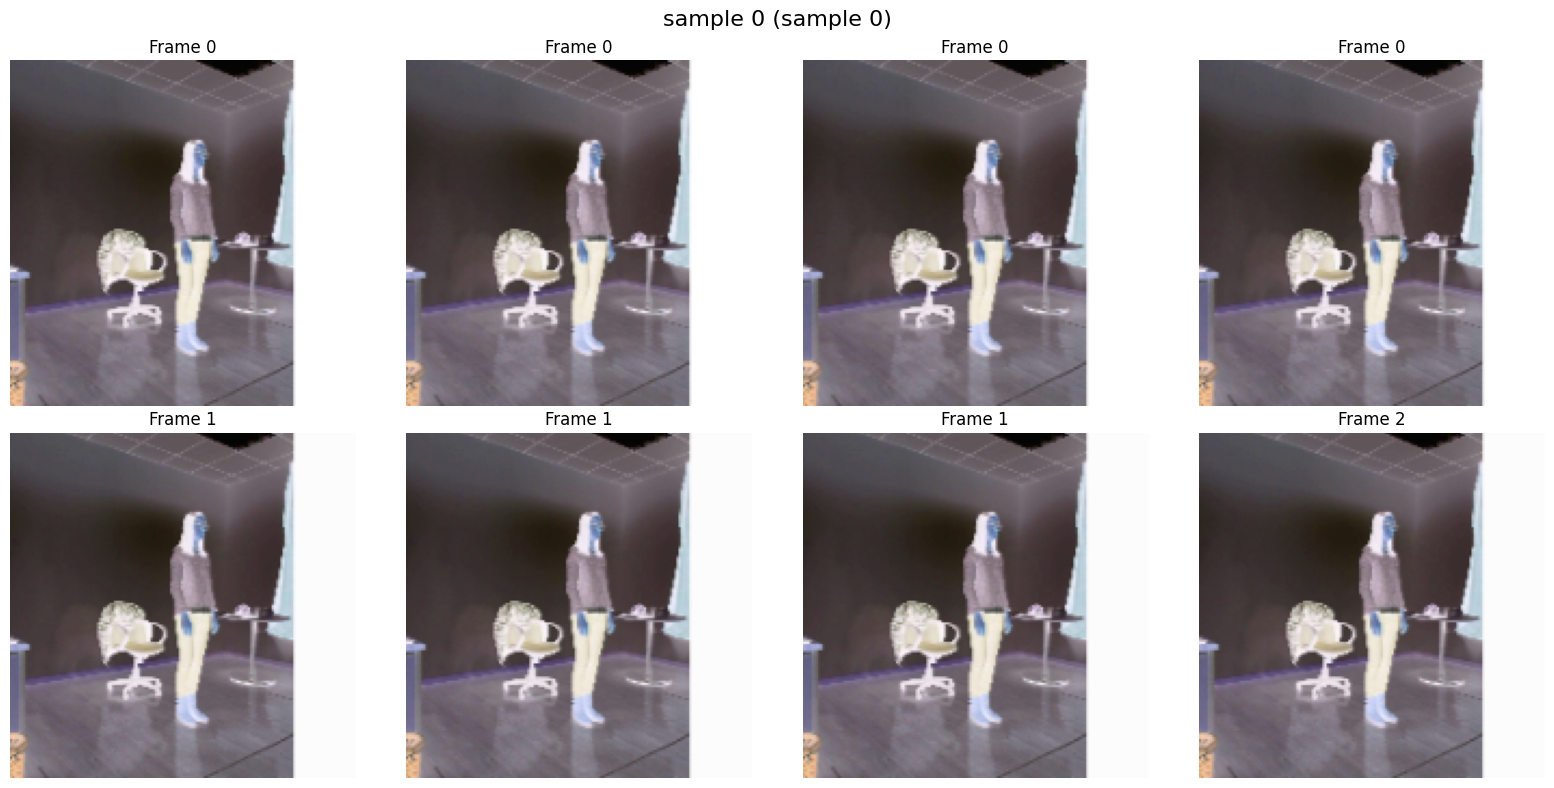

 pku annotation info (sample 0): 
 annotation nums: 3
 annotation 1: label 14, segment: [0.0, 63.0]
 annotation 2: label 12, segment: [122.0, 190.0]
 annotation 3: label 44, segment: [246.0, 420.0]
 pku metadata (sample 0): 
 video_name: 0154-L
 data_path: F:/dataset/pku-mmd/rgb
 fps: 30.0
 duration: 3572
 snippet_stride: 1
 window_size: 512
 offset_frames: 0
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])
Sample inputs shape: torch.Size([1, 3, 512, 160, 160])


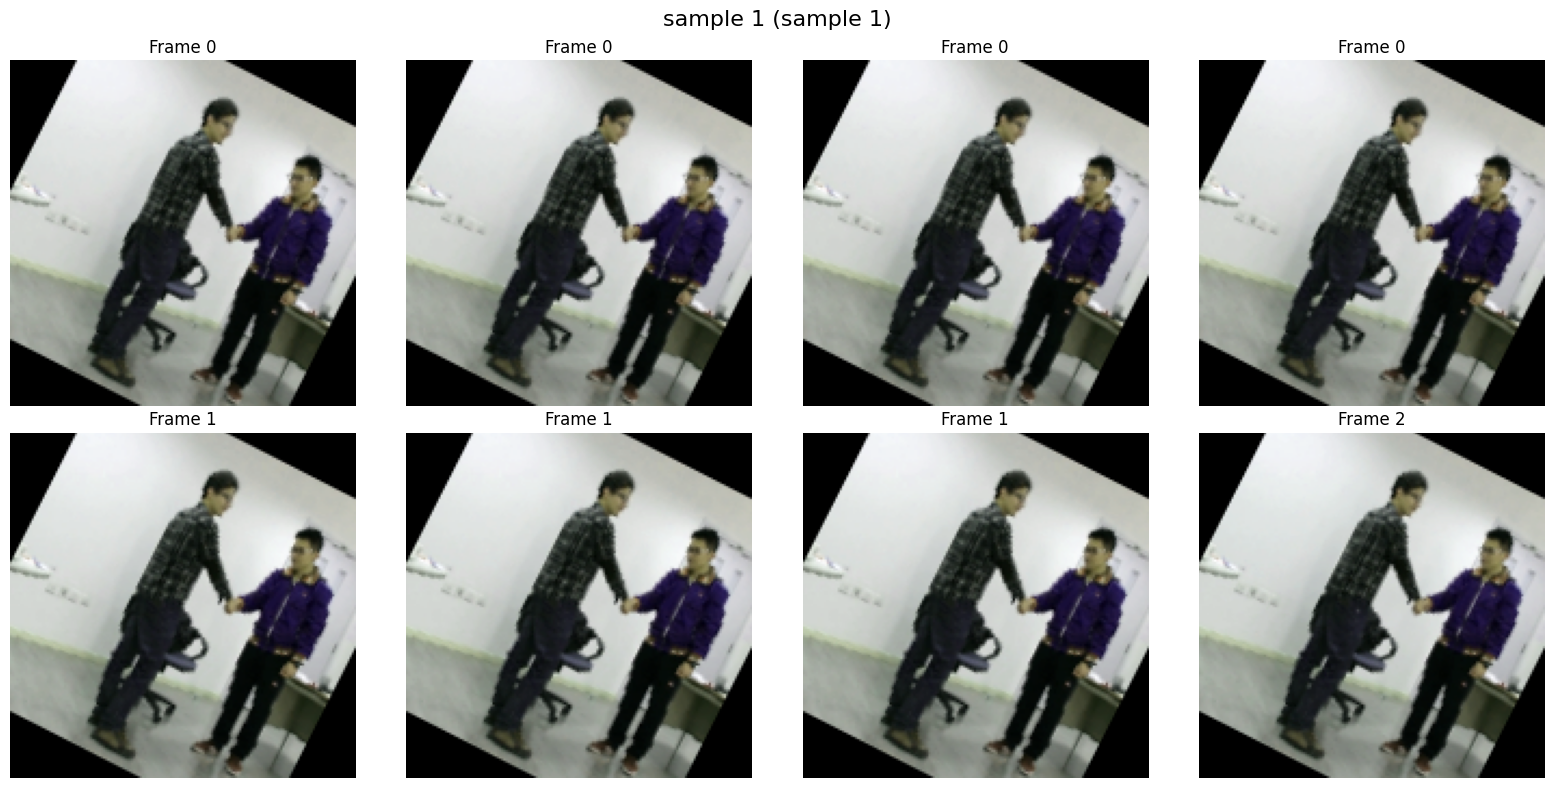

 pku annotation info (sample 1): 
 annotation nums: 3
 annotation 1: label 23, segment: [77.0, 162.0]
 annotation 2: label 17, segment: [281.0, 325.0]
 annotation 3: label 25, segment: [477.0, 512.0]
 pku metadata (sample 1): 
 video_name: 0350-R
 data_path: F:/dataset/pku-mmd/rgb
 fps: 30.0
 duration: 1601
 snippet_stride: 1
 window_size: 512
 offset_frames: 0


In [125]:
if 'data_dict' in locals():
    visualize_pku_batch_sample(data_dict, sample_idx=0, title="sample 0")

    if data_dict['inputs'].shape[0] > 1:
        visualize_pku_batch_sample(data_dict, sample_idx=1, title="sample 1")

else:
    print("no batch data")